<a href="https://colab.research.google.com/github/LorenzoGianassi/Progetto_AI/blob/master/Tesi_Finale.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from timeit import default_timer as timer
from torch.utils.data import Subset
import os
import sys
import random
import copy
from torch.backends import cudnn


# associo cuda per lavorare ulla gpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)
                #####################################################################################
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


# funzioni per spezzare un trainset\testset in tasks
def idx_tasks(num_tasks,trainset):   # genero un np array e splitto in task
    targets = trainset.targets
    targets = list(set(targets)) # provare a metter np:unique
    b = np.random.permutation(len(targets))
    tasks = []
    tasks = np.split(b,num_tasks,axis=0)
    return tasks # ritorno gli indici per poi usare nella funzione successiva

def split_tasks(trainset,index): # scorro il trainset e faccio append degli indici dei tasks
    tasks_indeces=[]
    final_tasks=[]
    for i in index :
      task = []
      for j in range(len(trainset)):
            current_class = trainset[j][1]
            if current_class in i:
              task.append(j)
      tasks_indeces.append(task) 
    for tsk in tasks_indeces:
      tmp_trainset=Subset(trainset, tsk)
      final_tasks.append(tmp_trainset)
    return final_tasks

def trainloader_split(trainset):  
        idx = idx_tasks(2,trainset)  # indici relativi al trainset
        trainsets = split_tasks(trainset,idx) # split del task
        trainloaders = []
        for tr in trainsets:
          trainloader_tmp = torch.utils.data.DataLoader(tr, batch_size=128,
                                              shuffle=True, num_workers=4)  
          trainloaders.append(trainloader_tmp)
        return trainloaders  

                #####################################################################################
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()




classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        #self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        #x = self.fc3(x)
        return x

                #####################################################################################
def train(trainloader,optimizer,criterion,net):
    for epoch in range(20):  # loop over the dataset multiple times
        start = timer()
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            
            inputs, labels = data[0].to(device), data[1].to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

           
        end = timer()
        print("Tempo dell'epoca ",epoch,"uguale a: ", (end - start), "sec")
    print('ALLENAMENTO FINITO')
    print("################################")    
                #####################################################################################
# metodo per eseguire il test
def test(testloader,net):
    # accuracy dell'intero network
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
           
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1) # torna il valore max della tupla
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: %d %%' % (
            100 * correct / total)) 
    # quale classe ha la migliore performance
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(4):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    for i in range(10):
        print('Accuracy of %5s : %2d %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))
    print("################################")    
                           #####################################################################################

# Esecuzione dei programmi
net = Net()

net.to(device)
net.add_module("fc3_1", nn.Linear(84, 10))
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) 


loaders = trainloader_split(trainset)
testloader = torch.utils.data.DataLoader(testset, batch_size=128,
                                         shuffle=True, num_workers=4)

train(loaders[0],optimizer,criterion,net)
test(testloader, net)


PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

net1 = Net()
#net.load_state_dict(torch.load(PATH))


# Parameters of newly constructed modules have requires_grad=True by default
#num_ftrs = net.fc2.out_features
net1.add_module("fc3_2", nn.Linear(84, 10))

net = net.to(device)
criterion_new = nn.CrossEntropyLoss()
optimizer_new = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
train(loaders[1],optimizer_new,criterion_new, net)
test(testloader, net)

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from timeit import default_timer as timer
from torch.utils.data import Subset
import os
import sys
import random
import copy
from torch.backends import cudnn
from torch.utils.data import Dataset 
import copy

  
                                          ###########################################################################

# CLASSE IL DATASET FILTRATO
class Filtered_Dataset(Dataset): 
  def __init__(self, dataset, indices, offset=0):
        self.indices = indices # indici dei target di cui ci interessa il target
        self.original_indices = [i for i in range(len(trainset.targets)) if trainset.targets[i] in indices] # filtraggio degli indici del dataset che voglio nel subset
        self.dataset = Subset(dataset, self.original_indices)
        self.original2task = { indices[i]  : offset + i for i in range(0,  len(indices) ) } # remapping degli indici con chiavi i valori degli indici del del task
        self.task2original = dict({ (val, key) for (key, val) in self.original2task.items() }) # remapping degli indici con chiavi i valori degli indici del del task
        
  def __getitem__(self, idx):
        (x, y) = self.dataset[idx]
        return (x, self.original2task[y])

  def __len__(self):
        return len(self.original_indices)
  

                                          ###########################################################################
# CLASSE RETE NEURALE
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
       

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.task_fc(x)
        
        return x  
                                       ###########################################################################

# CARICAMENTO E TRASFORM DEL DATASET

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# associo cuda per lavorare ulla gpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


print(device)
               
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


                                          ###########################################################################

# METODO PER SPLITTARE GLI INDICI DEI TARGET DEL TRAINSET/TESTSET
def idx_tasks(num_tasks,trainset):   # genero un np array e splitto in task
  targets = np.unique(trainset.targets)
  b = np.random.permutation(len(targets))
  tasks = []
  tasks = np.split(b,num_tasks,axis=0)
  return tasks # ritorno gli indici per poi usare nella funzione successiva

                                   #####################################################################################

# METODO CHE ESEGUE IL TRAIN DELLA RETE                                   
def train(trainloader,optimizer,criterion,net):
    for epoch in range(20):  # loop over the dataset multiple times
        start = timer()
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device) 
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

           
        end = timer()
        print("Tempo dell'epoca ",epoch,"uguale a: ", (end - start), "sec")
    print('ALLENAMENTO FINITO')
    print("################################")    
                #####################################################################################

# METODO PER ESEGUIRE IL TEST DELLA RETE
def test(testloader,net,task_train):
    # accuracy dell'intero network
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
           
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1) # torna il valore max della tupla

            for keys in task_train.task2original:
                predicted[predicted == keys]=task_train.task2original[keys]
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: %d %%' % (
            100 * correct / total)) 
    # quale classe ha la migliore performance
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            
            _, predicted = torch.max(outputs, 1)
            print('predicted vale : ',predicted)
            for keys in task_train.task2original:
                predicted[predicted == keys]=task_train.task2original[keys]
            c = (predicted == labels).squeeze()
            for i in range(4):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    for i in range(10):
        print('Accuracy of %5s : %2d %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))
    print("################################")      

                                          ###########################################################################
# ROUTINE DI TRAINING E TSET PER IL CONTINUAL LEARNING
def continual_learning(num_tasks,trainset,testset):
  indices = idx_tasks(num_tasks,trainset)
  train_tasks = []
  trainloaders = []
  test_tasks = []
  testloaders = []
  offset = 0
  net = Net()
  net.to(device)
  testloader = torch.utils.data.DataLoader(testset, batch_size=128,
                                         shuffle=True, num_workers=4)
  
  for idx in range(0,len(indices)):
    tmp_task_train = Filtered_Dataset(trainset, indices[idx],offset)
    offset += len(indices[idx]) # se splittiamo in due sarà 0-4
    train_tasks.append(tmp_task_train)
    tmp_trainloader = torch.utils.data.DataLoader(tmp_task_train, batch_size=128,
                                              shuffle=True, num_workers=4)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) 
    trainloaders.append(tmp_trainloader)
    if idx != 0:
      net.load_state_dict(torch.load(PATH))
      for param in net.parameters():
          param.requires_grad = False
       
    net.add_module("task_fc", nn.Linear(84, offset))
    if idx != 0:
       optimizer = optim.SGD(net.task_fc.parameters(), lr=0.001, momentum=0.9)    
    #net.task_fc = nn.Linear(84,offset)
    optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)   
    net.to(device)
    train(tmp_trainloader,optimizer,criterion,net)
    PATH = './cifar_net.pth'
    torch.save(net.state_dict(), PATH)
    test(testloader,net,tmp_task_train)
    input = torch.randn(1, 3, 32, 32)
    input.to(device)
    print(net(input))
  return(train_tasks,trainloaders,net)

                                       ###########################################################################
# ESECUZIONE DEI METODI

train_tasks,trainloaders,trained_net = continual_learning(2, trainset, testset)


input = torch.randn(1, 3, 32, 32)
trained_net(input)

In [ ]:
#print(trained_net)


classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

class Net(nn.Module):
    def __init__(self,numtasks):
        super(Net, self).__init__()
        self.numtasks = numtasks
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x1 = self.fc3(x)
        x2 = self.fc4(x)
        return x1, x2


# METODO CHE ESEGUE IL TRAIN DELLA RETE                                   
def train(trainloader,optimizer,criterion,net):
    for epoch in range(20):  # loop over the dataset multiple times
        start = timer()
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device) 
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = 0
            for out in outputs:
                tmp_loss = criterion(out, labels)
                loss+= tmp_loss    
            loss.backward()
            optimizer.step()

           
        end = timer()
        print("Tempo dell'epoca ",epoch,"uguale a: ", (end - start), "sec")
    print('ALLENAMENTO FINITO')
    print("################################")    
                                    
                         ##########################################################################



# METODO PER ESEGUIRE IL TEST DELLA RETE
def test(testloader,net):
    # accuracy dell'intero network
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
           
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1) # torna il valore max della tupla
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: %d %%' % (
            100 * correct / total)) 
    # quale classe ha la migliore performance
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            print(outputs)
            _, predicted = torch.max(outputs, 1)

            c = (predicted == labels).squeeze()
            for i in range(4):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    for i in range(10):
        print('Accuracy of %5s : %2d %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))
    print("################################")      

                                          ###########################################################################
net = Net(2)

input = torch.randn(1, 3, 32, 32)
print(net)
params = list(net.parameters())
print(len(params))
net.add_module("fc3", nn.Linear(84, 5))
net.add_module("fc4", nn.Linear(84, 5))
print(net)
params = list(net.parameters())
print(len(params))
out = net(input)
print(out)

indices = idx_tasks(2,trainset)
tmp_task_train = Filtered_Dataset(trainset, indices[0],0)
tmp_trainloader = torch.utils.data.DataLoader(tmp_task_train, batch_size=128,
                                              shuffle=True, num_workers=4)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) 
train(tmp_trainloader,optimizer,criterion,net)
print(net(input))
for p in net.fc3.parameters():
    p.requires_grad = False
for p in net.fc4.parameters():
  p.requires_grad = True    
tmp_task_train2 = Filtered_Dataset(trainset, indices[1],0)
tmp_trainloader2 = torch.utils.data.DataLoader(tmp_task_train2, batch_size=128,
                                              shuffle=True, num_workers=4)
net.eval()
train(tmp_trainloader2,optimizer,criterion,net)
print(net(input))
#testloader = torch.utils.data.DataLoader(testset, batch_size=128,
#                                         shuffle=True, num_workers=4)
  
#test(testloader,net)

In [ ]:


classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        #self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x1 = self.fc3(x)
        x2 = self.fc4(x)
        return x1, x2

net = Net()

input = torch.randn(1, 3, 32, 32)
print(net)
params = list(net.parameters())
print(len(params))
net.add_module("fc3", nn.Linear(84, 5))
net.add_module("fc4", nn.Linear(84, 10))
print(net)
params = list(net.parameters())
print(len(params))
out = net(input)
print(out)

In [ ]:
# TODO: Train/test this two-task problem.
# Psuedocode:
#  0. Create "backbone" network.
#  1. For t in tasks:
#     1a. Add new classification module for task t
#     1b. Train network for task t.
#     1c. Save network
#     1d. Test network for all tasks up to task t.
#  2. Test network on all tasks.
#
# TODO: Test/evaluation code (up to task t)
# TODO: Make the split/train/test independent of magic constants.

In [ ]:
# PROVA ESECUZIONE DELLA ROUTINE DEL CONTINUAL LEARNING
def continual_learning(num_tasks,trainset,testset):
  indices = idx_tasks(num_tasks,trainset)
  train_tasks = []
  trainloaders = []
  test_tasks = []
  testloaders = []
  offset = 0
  net = Net()
  net.to(device)
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) 
  for idx in range(0,len(indices)):
    tmp_task_train = Filtered_Dataset(trainset, indices[idx],offset)
    print(tmp_task_train.original2task)
    offset += len(indices[idx]) # se splittiamo in due sarà 0-4
    train_tasks.append(tmp_task_train)
    tmp_trainloader = torch.utils.data.DataLoader(tmp_task_train, batch_size=128,
                                              shuffle=True, num_workers=4)
    trainloaders.append(tmp_trainloader)
    net.add_module("task_fc"+str(idx), nn.Linear(84, offset))
    train(tmp_trainloader,optimizer,criterion,net)
  return(train_tasks,trainloaders,net)

                                       ###########################################################################

a,b,c = continual_learning(2,trainset,testset)
testloader = torch.utils.data.DataLoader(testset, batch_size=128,
                                         shuffle=True, num_workers=4)
test(testloader,c)


In [ ]:
from torch.utils.data import Dataset 
import copy
# funzioni per spezzare un trainset\testset in tasks
def idx_tasks(num_tasks,trainset):   # genero un np array e splitto in task
  targets = np.unique(trainset.targets)
  b = np.random.permutation(len(targets))
  tasks = []
  tasks = np.split(b,num_tasks,axis=0)
  return tasks # ritorno gli indici per poi usare nella funzione successiva
  
                                          ###########################################################################

class Filtered_Dataset(Dataset): #classe che crea un nuovo datset filtrato
  def __init__(self, dataset, indices, offset=0):
        self.indices = indices # indici dei target di cui ci interessa il target
        self.original_indices = [i for i in range(len(trainset.targets)) if trainset.targets[i] in indices] # filtraggio degli indici del dataset che voglio nel subset
        self.dataset = Subset(dataset, self.original_indices)
        self.original2task = { indices[i]  : offset + i for i in range(0,  len(indices) ) } # remapping degli indici con chiavi i valori degli indici del del task
        self.task2original = dict({ (val, key) for (key, val) in self.original2task.items() }) # remapping degli indici con chiavi i valori degli indici del del task
        
  def __getitem__(self, idx):
        (x, y) = self.dataset[idx]
        return (x, self.original2task[y])

  def __len__(self):
        return len(self.original_indices)
  
  
                                       ###########################################################################

idx = idx_tasks(2,trainset)
task1_train = Filtered_Dataset(trainset, idx[0])
task2_train = Filtered_Dataset(trainset, idx[1],len(idx[0]))  
task1_test = Filtered_Dataset(testset, idx[0])
task2_test = Filtered_Dataset(testset, idx[1], len(idx[0]))
trainloader1 = torch.utils.data.DataLoader(task1_train, batch_size=128,
                                              shuffle=True, num_workers=4)  
trainloader2 = torch.utils.data.DataLoader(task2_train, batch_size=128,
                                              shuffle=True, num_workers=4)

testloader = torch.utils.data.DataLoader(testset, batch_size=128,
                                         shuffle=True, num_workers=4)
testloader1 = torch.utils.data.DataLoader(task1_test, batch_size=128,
                                         shuffle=True, num_workers=4)
testloader2 = torch.utils.data.DataLoader(task2_test, batch_size=128,
                                         shuffle=True, num_workers=4)

                                       ###########################################################################

net = Net()

net.to(device)
net.add_module("fc3_1", nn.Linear(84, 5))
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) 


loaders = trainloader_split(trainset)
testloader = torch.utils.data.DataLoader(testset, batch_size=128,
                                         shuffle=True, num_workers=4)

train(trainloader1,optimizer,criterion,net)
#test(testloader1, net)


PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

net.add_module("fc3_2", nn.Linear(84, 10))

net = net.to(device)
criterion_new = nn.CrossEntropyLoss()
optimizer_new = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
train(trainloader2,optimizer_new,criterion_new, net)
test(testloader, net)


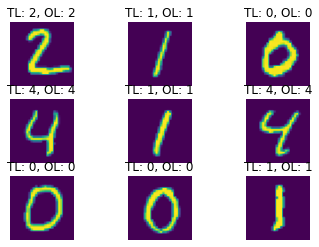

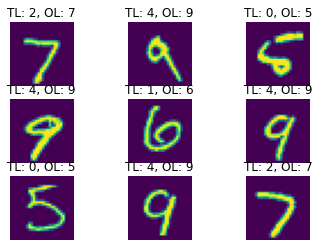

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Network output with task 0 set:
tensor([[-1.6142, -1.6609, -1.5650, -1.5969, -1.6125],
        [-1.6147, -1.6756, -1.5568, -1.5900, -1.6138],
        [-1.6073, -1.6595, -1.5853, -1.5733, -1.6241],
        [-1.5923, -1.6687, -1.5867, -1.5957, -1.6059],
        [-1.6191, -1.6595, -1.5773, -1.5842, -1.6092],
        [-1.5988, -1.6774, -1.5786, -1.5824, -1.6132],
        [-1.6231, -1.6566, -1.5737, -1.5834, -1.6127],
        [-1.5991, -1.6671, -1.5771, -1.5907, -1.6156],
        [-1.6128, -1.6534, -1.5817, -1.5973, -1.6035],
        [-1.6071, -1.6457, -1.5808, -1.5974, -1.6175],
        [-1.6208, -1.6494, -1.5712, -1.5873, -1.6203],
        [-1.6018, -1.6620, -1.5764, -1.5859, -1.6233],
        [-1.5966, -1.6707, -1.5773, -1.5993, -1.6059],
        [-1.6082, -1.6605, -1.5680, -1.5933, -1.6196],
        [-1.6051, -1.6623, -1.5851, -1.5720, -1.6252],
        [-1.5946, -1.6620, -1.5706, -1.6008, -1.6216]], grad_fn=<CatBackward>)

Network output with task 1 set:
tensor([[-1.6274, -1.6219, -1.6

In [134]:
from itertools import islice
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, Subset
from torch.optim import SGD
import torchvision.transforms as T
from torchvision.datasets import MNIST
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from timeit import default_timer as timer
from torch.utils.data import Subset
import os
import sys
import random
import copy
from torch.backends import cudnn

# CLASSE IL DATASET FILTRATO
class FilteredDataset(Dataset):
    def __init__(self, dataset, indices, offset=0):
        self.indices = indices # indici dei target di cui ci interessa il target
        self.original_indices = [i for i in range(len(dataset.targets)) if dataset.targets[i] in indices] # filtraggio degli indici del dataset che voglio nel subset
        self.dataset = Subset(dataset, self.original_indices)
        self.original2task = { indices[i]  : offset + i for i in range(0,  len(indices) ) } # remapping degli indici con chiavi i valori degli indici del del task
        self.task2original = dict({ (val, key) for (key, val) in self.original2task.items() }) # remapping degli indici con chiavi i valori degli indici del del task

    def __getitem__(self, idx):
        (x, y) = self.dataset[idx]
        return (x, self.original2task[y])

    def __len__(self):
        return len(self.original_indices)

# A CNN for multi-task classification.
class Net(nn.Module):
    # Constructor takes in input the important hyper parameters of the networ.
    def __init__(self, image_size=28, image_channels=1, kernel=3, numFM1=32, numFM2=64, numFC1=256, numFC2=256):
        super(Net, self).__init__()
        self.numFC2 = numFC2
        self.conv1 = nn.Conv2d(image_channels, numFM1, kernel, padding=kernel//2)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(numFM1, numFM2, kernel, padding=kernel//2)
        self.fc1 = nn.Linear(numFM2 * ((image_size // 4)**2), numFC1)
        self.fc2 = nn.Linear(numFC1, numFC2)


        self.task_fcs = []       # Will hold all Linear layers for classification heads.
        self.current_tasks = []  # Selects which task(s) are currently active.

    # Forward pass of the network: returns ONLY currently selected tasks.
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.flatten(1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        # Concatenates the classification heads of selected tasks.
        outputs = torch.cat([F.log_softmax(self.task_fcs[t](x)) for t in self.current_tasks], 1)
        return outputs

    # Add a new classification head with num_classes outputs.
    def add_task(self, num_classes):
        fc = nn.Linear(self.numFC2, num_classes)
        self.add_module(name=f'task{len(self.task_fcs)}_fc', module=fc)
        self.task_fcs.append(fc)

    # Set the current task(s) -- takes a *LIST* of task ids.
    def set_tasks(self, tasks):
        self.current_tasks = tasks

# Function to visualize a batch of images from a dataloader over a filtered
# dataset. This shows each image, the task label within each task, and the
# original label. This lets us verify that FilteredDataset is working.
def verify_dataloaders(dls):
    for (t, dl) in enumerate(dls):
        plt.figure()
        plt.title(f'Task: {t}')
        batch = dl.__iter__().__next__()
        for (i, (im, label)) in islice(enumerate(zip(*batch)), 9):
            plt.subplot(3, 3, i+1)
            plt.axis(False)
            plt.imshow(im[0])
            plt.title(f'TL: {label}, OL: {dl.dataset.task2original[int(label)]}')
        plt.show()

# Function that verifies that the network is working the way we need it to.
# Verifies that only selected task heads are returned, and that when training
# only currently selected heads are modified.
def verify_network(net, dls):
    # Get a batch of images and labels from both dataloader.
    [(xs0, ys0)] = list(islice(task_train_dls[0], 1))
    [(xs1, ys1)] = list(islice(task_train_dls[1], 1))

    # Add classification heads for all tasks to the network.
    net.add_task(5)
    net.add_task(5)

    # Run images through the network with various tasks set.
    net.set_tasks([0])
    print(f'Network output with task 0 set:\n{net(xs0)}\n')
    net.set_tasks([1])
    print(f'Network output with task 1 set:\n{net(xs0)}\n')
    net.set_tasks([0, 1])
    print(f'Network output with tasks 0 and 1 set:\n{net(xs0)}')

    # Print the norm of the fc weights for tracking -- this is a cheap way to
    # see if the weights are being changed during training.
    print(f'Task 0 weight norm BEFORE training: {torch.norm(net.task_fcs[0].weight)}')
    print(f'Task 1 weight norm BEFORE training: {torch.norm(net.task_fcs[1].weight)}')

    # Run a single optimization loop on task 0.
    optimizer = SGD(net.parameters(), lr=1e-3)
    optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
    net.set_tasks([0])
    net.train()
    for (i, (xs, ys)) in enumerate(dls[0]):
        optimizer.zero_grad()
        output = net(xs)
        loss = F.nll_loss(output, ys)
        loss.backward()
        optimizer.step()

    # Print the norm of the fc weights for tracking.
    print(f'Task 0 weight norm AFTER training task 0: {torch.norm(net.task_fcs[0].weight)}')
    print(f'Task 1 weight norm AFTER training task 0: {torch.norm(net.task_fcs[1].weight)}')

    # And do the same thing for task 1.
    optimizer.zero_grad()
    net.set_tasks([1])
    net.train()
    for (i, (xs, ys)) in enumerate(dls[1]):
        optimizer.zero_grad()
        output = net(xs)
        loss = F.nll_loss(output, ys)
        loss.backward()
        optimizer.step()

    # Print the norm of the fc weights for tracking.
    print(f'Task 0 weight norm AFTER training task 1: {torch.norm(net.task_fcs[0].weight)}')
    print(f'Task 1 weight norm AFTER training task 1: {torch.norm(net.task_fcs[1].weight)}')

# Put all experiment hyperparameters HERE.
batch_size = 16
verify_dls = True
verify_net = True

if __name__ == '__main__':
    # Use a standard transformation on ALL dataets.
    transform = T.Compose([T.ToTensor(), T.Normalize((0.1307,), (0.3081,))])

    # Load the MNIST training and test sets.
    ds_train = MNIST('./data/', train=True, download=True, transform=transform)
    ds_test = MNIST('./data/', train=False, download=True, transform=transform)
    
    #ds_train = torchvision.datasets.CIFAR10(root='./data', train=True,
    #                                  download=True, transform=transform)
    #ds_test = torchvision.datasets.CIFAR10(root='./data', train=False,
    #                                   download=True, transform=transform)
    # Create our task datasets and dataloaders for both training and testing.
    tasks = [(0, 1, 2, 3, 4), (5, 6, 7, 8, 9)]
    task_train_dss = [FilteredDataset(ds_train, classes) for classes in tasks]
    task_train_dls = [DataLoader(ds, batch_size=batch_size) for ds in task_train_dss]
    task_test_dss = [FilteredDataset(ds_test, classes) for classes in tasks]
    task_test_dls = [DataLoader(ds, batch_size=batch_size) for ds in task_test_dss]

    # If verify flag is set, run the dataloader verification.
    if verify_dls:
        verify_dataloaders(task_test_dls)

    # Instantiate a network.
    net = Net()

    # If verivy flag set, run network verification.
    if verify_net:
        verify_network(net, task_train_dls)

In [ ]:
input = torch.randn(1, 1, 28, 28)
net(input)

In [163]:

from itertools import islice
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, Subset
from torch.optim import SGD
import torchvision.transforms as T
from torchvision.datasets import MNIST
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from timeit import default_timer as timer
from torch.utils.data import Subset
import os
import sys
import random
import copy
from torch.backends import cudnn

# associo cuda per lavorare ulla gpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)
                #####################################################################################
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


# funzioni per spezzare un trainset\testset in tasks
def idx_tasks(num_tasks,trainset):   # genero un np array e splitto in task
    targets = trainset.targets
    targets = list(set(targets)) # provare a metter np:unique
    b = np.random.permutation(len(targets))
    tasks = []
    tasks = np.split(b,num_tasks,axis=0)
    return tasks # ritorno gli indici per poi usare nella funzione successiva



                #####################################################################################


classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

class Net(nn.Module):

  def __init__(self,numFC2=84):
      super(Net, self).__init__()
      self.numFC2 = numFC2
      self.conv1 = nn.Conv2d(3, 6, 5)
      self.pool = nn.MaxPool2d(2, 2)
      self.conv2 = nn.Conv2d(6, 16, 5)
      self.fc1 = nn.Linear(16 * 5 * 5, 120)
      self.fc2 = nn.Linear(120, numFC2)
      self.task_fcs = []       # Will hold all Linear layers for classification heads.
      self.current_tasks = []  # Selects which task(s) are currently active.


  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    #x = x.view(-1, 16 * 5 * 5)
    x = x.flatten(1)
    x = F.relu(self.fc1(x))
    x =F.relu (self.fc2(x))
    # Concatenates the classification heads of selected tasks.
    outputs = torch.cat([F.log_softmax(self.task_fcs[t](x)) for t in self.current_tasks], 1)
    #outputs = torch.cat([(self.task_fcs[t](x)) for t in self.current_tasks], 1)
    return outputs

  # Add a new classification head with num_classes outputs.
  def add_task(self, num_classes):
      fc = nn.Linear(self.numFC2, num_classes)
      self.add_module(name=f'task{len(self.task_fcs)}_fc', module=fc)
      self.task_fcs.append(fc)

  # Set the current task(s) -- takes a *LIST* of task ids.
  def set_tasks(self, tasks):
      self.current_tasks = tasks


                                         ###########################################################################

# CLASSE IL DATASET FILTRATO
class Filtered_Dataset(Dataset): 
  def __init__(self, dataset, indices, offset=0):
        self.indices = indices # indici dei target di cui ci interessa il target
        self.original_indices = [i for i in range(len(trainset.targets)) if trainset.targets[i] in indices] # filtraggio degli indici del dataset che voglio nel subset
        self.dataset = Subset(dataset, self.original_indices)
        self.original2task = { indices[i]  : offset + i for i in range(0,  len(indices) ) } # remapping degli indici con chiavi i valori degli indici del del task
        self.task2original = dict({ (val, key) for (key, val) in self.original2task.items() }) # remapping degli indici con chiavi i valori degli indici del del task
        
  def __getitem__(self, idx):
        (x, y) = self.dataset[idx]
        return (x, self.original2task[y])

  def __len__(self):
        return len(self.original_indices)


                                          ###########################################################################

# METODO PER SPLITTARE GLI INDICI DEI TARGET DEL TRAINSET/TESTSET
def idx_tasks(num_tasks,trainset):   # genero un np array e splitto in task
  targets = np.unique(trainset.targets)
  b = np.random.permutation(len(targets))
  tasks = []
  tasks = np.split(b,num_tasks,axis=0)
  return tasks # ritorno gli indici per poi usare nella funzione successiva

                                   #####################################################################################

# METODO CHE ESEGUE IL TRAIN DELLA RETE                                   
def train(trainloader,optimizer,criterion,net):
    for epoch in range(20):  # loop over the dataset multiple times
        start = timer()
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device) 
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

           
        end = timer()
        print("Tempo dell'epoca ",epoch,"uguale a: ", (end - start), "sec")
    print('ALLENAMENTO FINITO')
    print("################################")    
                #####################################################################################

# METODO PER ESEGUIRE IL TEST DELLA RETE
def test(testloader,net,task_train):
    # accuracy dell'intero network
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
           
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1) # torna il valore max della tupla
            for i in range(0,len(task_train)):
                for keys in task_train[i].task2original:
                    predicted[predicted == keys]=task_train[i].task2original[keys]
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: %d %%' % (
            100 * correct / total)) 
    # quale classe ha la migliore performance
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            
            _, predicted = torch.max(outputs, 1)
            for i in range(0,len(task_train)):
                for keys in task_train[i].task2original:
                    predicted[predicted == keys]=task_train[i].task2original[keys]
            c = (predicted == labels).squeeze()
            for i in range(4):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    for i in range(10):
        print('Accuracy of %5s : %2d %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))
    print("################################")      

                                          ###########################################################################
# ROUTINE DI TRAINING E TSET PER IL CONTINUAL LEARNING
def continual_learning(num_tasks,trainset,testset):
  indices = idx_tasks(num_tasks,trainset)
  train_tasks = []
  trainloaders = []
  test_tasks = []
  testloaders = []
  offset = 0
  net = Net()
  net.to(device)
  testloader = torch.utils.data.DataLoader(testset, batch_size=128,
                                         shuffle=True, num_workers=4)
  
  for idx in range(0,len(indices)):
    tasks = []
    tasks.append(idx)
    tmp_task_train = Filtered_Dataset(trainset, indices[idx],offset)
    offset += len(indices[idx]) # se splittiamo in due sarà 0-4
    train_tasks.append(tmp_task_train)
    tmp_trainloader = torch.utils.data.DataLoader(tmp_task_train, batch_size=128,
                                              shuffle=True, num_workers=4)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) 
    trainloaders.append(tmp_trainloader)
    if idx != 0:
      net.load_state_dict(torch.load(PATH))
       
    net.add_task(5)
    net.set_tasks(tasks)
    net.to(device)
    train(tmp_trainloader,optimizer,criterion,net)
    PATH = './cifar_net.pth'
    torch.save(net.state_dict(), PATH)
    test(testloader,net,tmp_task_train)
  return(train_tasks,trainloaders,net)

                                       ###########################################################################  

# Function to visualize a batch of images from a dataloader over a filtered
# dataset. This shows each image, the task label within each task, and the
# original label. This lets us verify that FilteredDataset is working.
def verify_dataloaders(dls):
    for (t, dl) in enumerate(dls):
        plt.figure()
        plt.title(f'Task: {t}')
        batch = dl.__iter__().__next__()
        for (i, (im, label)) in islice(enumerate(zip(*batch)), 9):
            plt.subplot(3, 3, i+1)
            plt.axis(False)
            plt.imshow(im[0])
            plt.title(f'TL: {label}, OL: {dl.dataset.task2original[int(label)]}')
        plt.show()

# Function that verifies that the network is working the way we need it to.
# Verifies that only selected task heads are returned, and that when training
# only currently selected heads are modified.
def verify_network(net, dls):
    # Get a batch of images and labels from both dataloader.
    [(xs0, ys0)] = list(islice(task_train_dls[0], 1))
    [(xs1, ys1)] = list(islice(task_train_dls[1], 1))

    # Add classification heads for all tasks to the network.
    net.add_task(5)
    net.add_task(5)

    # Run images through the network with various tasks set.
    net.set_tasks([0])
    print(f'Network output with task 0 set:\n{net(xs0)}\n')
    net.set_tasks([1])
    print(f'Network output with task 1 set:\n{net(xs0)}\n')
    net.set_tasks([0, 1])
    print(f'Network output with tasks 0 and 1 set:\n{net(xs0)}')

    # Print the norm of the fc weights for tracking -- this is a cheap way to
    # see if the weights are being changed during training.
    print(f'Task 0 weight norm BEFORE training: {torch.norm(net.task_fcs[0].weight)}')
    print(f'Task 1 weight norm BEFORE training: {torch.norm(net.task_fcs[1].weight)}')

    # Run a single optimization loop on task 0.
    optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
    criterion = nn.CrossEntropyLoss()
    #criterion = F.nll_loss()
    net.set_tasks([0])
    net.train()
    train(dls[0],optimizer,criterion,net)
    """
    for (i, (xs, ys)) in enumerate(dls[0]):
        optimizer.zero_grad()
        output = net(xs)
        #loss = F.nll_loss(output, ys)
        loss = criterion(output, ys)
        loss.backward()
        optimizer.step()
     """
    # Print the norm of the fc weights for tracking.
    print(f'Task 0 weight norm AFTER training task 0: {torch.norm(net.task_fcs[0].weight)}')
    print(f'Task 1 weight norm AFTER training task 0: {torch.norm(net.task_fcs[1].weight)}')

    # And do the same thing for task 1.
    optimizer.zero_grad()
    net.set_tasks([1])
    net.train()
    train(dls[1],optimizer,criterion,net)
    """
    for (i, (xs, ys)) in enumerate(dls[1]):
        optimizer.zero_grad()
        output = net(xs)
        loss = criterion(output, ys)
        loss.backward()
        optimizer.step()
    """

    # Print the norm of the fc weights for tracking.
    print(f'Task 0 weight norm AFTER training task 1: {torch.norm(net.task_fcs[0].weight)}')
    print(f'Task 1 weight norm AFTER training task 1: {torch.norm(net.task_fcs[1].weight)}')

# Put all experiment hyperparameters HERE.
verify_dls = True
verify_net = True

if __name__ == '__main__':
    # Use a standard transformation on ALL dataets.
    transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    ds_train = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
    ds_test = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
    # Create our task datasets and dataloaders for both training and testing.
    #tasks = [(0, 1, 2, 3, 4), (5, 6, 7, 8, 9)]
    tasks = idx_tasks(2,ds_train)
    task_train_dss = [Filtered_Dataset(ds_train, classes) for classes in tasks]
    task_train_dls = [DataLoader(ds, batch_size=128) for ds in task_train_dss]
    task_test_dss = [Filtered_Dataset(ds_test, classes) for classes in tasks]
    task_test_dls = [DataLoader(ds, batch_size=128) for ds in task_test_dss]

    # If verify flag is set, run the dataloader verification.
   #if verify_dls:
   #    verify_dataloaders(task_train_dls)

    # Instantiate a network.
    net = Net()

    # If verivy flag set, run network verification.
    if verify_net:
        verify_network(net, task_train_dls)
       

cpu
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:86: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Network output with task 0 set:
tensor([[-1.5775, -1.6110, -1.6559, -1.6017, -1.6027],
        [-1.5703, -1.6195, -1.6542, -1.6013, -1.6037],
        [-1.5699, -1.6169, -1.6581, -1.5967, -1.6076],
        [-1.5581, -1.6200, -1.6653, -1.6034, -1.6034],
        [-1.5657, -1.6187, -1.6605, -1.6006, -1.6041],
        [-1.5639, -1.6183, -1.6598, -1.5932, -1.6144],
        [-1.5596, -1.6223, -1.6565, -1.5975, -1.6138],
        [-1.5774, -1.6196, -1.6525, -1.5992, -1.6001],
        [-1.5784, -1.6080, -1.6568, -1.5917, -1.6141],
        [-1.5685, -1.6135, -1.6599, -1.6043, -1.6031],
        [-1.5645, -1.6224, -1.6522, -1.5988, -1.6114],
        [-1.5743, -1.6080, -1.6626, -1.6048, -1.5995],
        [-1.5714, -1.6229, -1.6530, -1.5985, -1.6033],
        [-1.5738, -1.6131, -1.6610, -1.6027, -1.5986],
        [-1.5824, -1.6117, -1.6563, -1.5986, -1.5998],
        [-1.5588, -1.6306, -1.6596, -1.5938, -1.6072],
        [-1.5744, -1.6194, -1.6542, -1.5917, -1.6093],
        [-1.5820, -1.6147, -1.658

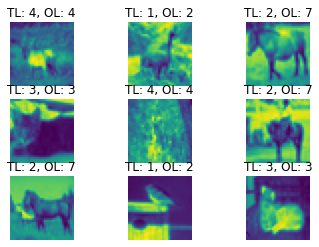

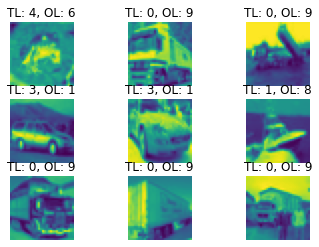

In [168]:
verify_dataloaders(task_train_dls)

In [165]:
input = torch.randn(1, 3, 32, 32)
net.set_tasks([0,1])
net(input)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:86: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


tensor([[-0.1060, -3.6161, -4.1426, -8.3108, -2.8542, -2.8707, -6.3053, -8.9623,
         -0.0656, -5.3259]], grad_fn=<CatBackward>)

In [166]:
testloader = torch.utils.data.DataLoader(testset, batch_size=128,
                                         shuffle=True, num_workers=4)
net.set_tasks([1])
test(testloader,net,task_train_dss) 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:86: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Accuracy of the network on the 10000 test images: 22 %
Accuracy of plane :  0 %
Accuracy of   car :  0 %
Accuracy of  bird :  0 %
Accuracy of   cat :  0 %
Accuracy of  deer :  0 %
Accuracy of   dog :  0 %
Accuracy of  frog : 91 %
Accuracy of horse : 60 %
Accuracy of  ship : 16 %
Accuracy of truck : 61 %
################################
